In [1]:
import torch
from collections import namedtuple
from utils import dataset_cached as dc
from utils import multiclass_dataset_cached as mdc
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
from utils.dataset_cached import CELEBA_EASY_LABELS
from utils.multiclass_dataset_cached import CELEBA_MULTI_LABELS, CELEBACached
from models.ccvae import CCVAE, mc_CCVAE
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL
import os


In [2]:
NUM_MC_LABELS = 1

In [3]:
# change root for mutlilabel (already dropped the nans within celebaCached)
mc_loaders = mdc.setup_data_loaders(False,
                                      200,
                                      cache_data=True,
                                      sup_frac=0.1,
                                      root='./data/datasets/celeba',
                                      multi_class=True)



Loading MULTI_CLASS dataset
Splitting Dataset
Loading MULTI_CLASS dataset
Loading MULTI_CLASS dataset
Loading MULTI_CLASS dataset


In [4]:

z_dim = 43 # To keep 27 dimensions for z\c and one per label (16 labels in the multi-class label setting)
im_shape = (3, 64, 64)
num_binary_classes = len(CELEBA_MULTI_LABELS)-1
num_mc_labels = 1
num_mc_classes = 5

mc_cc_vae = mc_CCVAE(z_dim=z_dim,
                   num_binary_classes=num_binary_classes,
                   im_shape=im_shape,
                   use_cuda=False,
                   num_mc_labels = num_mc_labels,
                   num_mc_classes = num_mc_classes)

In [5]:
ENCODER_PATH = './pretrained_weights/encoder.pt'
DECODER_PATH = './pretrained_weights/decoder.pt'
COND_PRIOR_BIN_PATH = './pretrained_weights/cond_prior_binary.pt'
CLASSIFIER_BIN_PATH = './pretrained_weights/classifier_binary.pt'
COND_PRIOR_MC_PATH = './pretrained_weights/cond_prior_mc.pt'
CLASSIFIER_MC_PATH = './pretrained_weights/classifier_mc.pt'

In [6]:

# Load weights for the encoder
encoder_checkpoint = torch.load(ENCODER_PATH)
mc_cc_vae.encoder.load_state_dict(encoder_checkpoint.state_dict())

# Load weights for the decoder
decoder_checkpoint = torch.load(DECODER_PATH)
mc_cc_vae.decoder.load_state_dict(decoder_checkpoint.state_dict())

# Load weights for the classifier
classifier_binary_checkpoint = torch.load(CLASSIFIER_BIN_PATH)
mc_cc_vae.classifier_binary.load_state_dict(classifier_binary_checkpoint.state_dict())

# Load weights for the conditional prior
cond_prior_binary_checkpoint = torch.load(COND_PRIOR_BIN_PATH)
mc_cc_vae.cond_prior_binary.load_state_dict(cond_prior_binary_checkpoint.state_dict())

# Load weights for the classifier
classifier_mc_checkpoint = torch.load(CLASSIFIER_MC_PATH)
mc_cc_vae.classifier_mc.load_state_dict(classifier_mc_checkpoint.state_dict())

# Load weights for the conditional prior
cond_prior_mc_checkpoint = torch.load(COND_PRIOR_MC_PATH)
mc_cc_vae.cond_prior_mc.load_state_dict(cond_prior_mc_checkpoint.state_dict())

# Make sure to set each component to evaluation mode if needed
mc_cc_vae.encoder.eval()
mc_cc_vae.decoder.eval()
mc_cc_vae.classifier_binary.eval()
mc_cc_vae.cond_prior_binary.eval()
mc_cc_vae.classifier_mc.eval()
mc_cc_vae.cond_prior_mc.eval()

CondPrior_mc(
  (diag_loc): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Parameter containing: [torch.float32 of size 1]
      (4): Parameter containing: [torch.float32 of size 1]
  )
  (diag_scale): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Parameter containing: [torch.float32 of size 1]
      (4): Parameter containing: [torch.float32 of size 1]
  )
)

## **1. Inference :**

**Reconstruct Images**

In [7]:
img_batch = CELEBACached.fixed_imgs
reconstructed_img_batch = mc_cc_vae.reconstruct_img(img_batch).view(-1, *im_shape)

In [8]:
img_idx =25
img = img_batch[img_idx,:,:,:]
reconstructed_img = reconstructed_img_batch[img_idx,:,:,:]

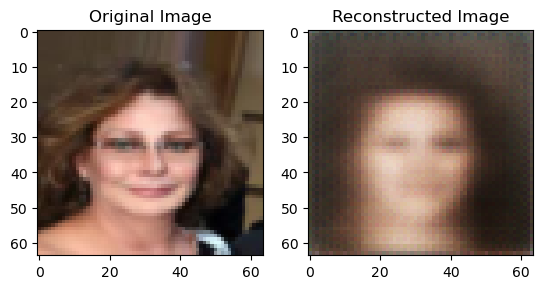

In [9]:
to_pil = transforms.ToPILImage()
image_pil = to_pil(img)
reconstructed_pil = to_pil(reconstructed_img)

# Plot the original image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title('Original Image')

# Plot the reconstructed image on the right
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_pil)
plt.title('Reconstructed Image')

# Display the plots
plt.show()



## Tests

In [11]:
for n_param, params in mc_cc_vae.named_parameters():
    print(n_param)
    # print(params)

encoder.encoder.0.weight
encoder.encoder.0.bias
encoder.encoder.2.weight
encoder.encoder.2.bias
encoder.encoder.4.weight
encoder.encoder.4.bias
encoder.encoder.6.weight
encoder.encoder.6.bias
encoder.encoder.8.weight
encoder.encoder.8.bias
encoder.locs.weight
encoder.locs.bias
encoder.scales.weight
encoder.scales.bias
decoder.decoder.0.weight
decoder.decoder.0.bias
decoder.decoder.3.weight
decoder.decoder.3.bias
decoder.decoder.5.weight
decoder.decoder.5.bias
decoder.decoder.7.weight
decoder.decoder.7.bias
decoder.decoder.9.weight
decoder.decoder.9.bias
decoder.decoder.11.weight
decoder.decoder.11.bias
classifier_binary.diag.weight
classifier_binary.diag.bias
cond_prior_binary.diag_loc_true
cond_prior_binary.diag_loc_false
cond_prior_binary.diag_scale_true
cond_prior_binary.diag_scale_false
classifier_mc.categorical_params.weight
classifier_mc.categorical_params.bias
cond_prior_mc.diag_loc.0
cond_prior_mc.diag_loc.1
cond_prior_mc.diag_loc.2
cond_prior_mc.diag_loc.3
cond_prior_mc.diag_l

In [12]:
import torch.distributions as dist
from torchvision.utils import make_grid, save_image
HAIR_ATTRIBUTES = ['Bald','Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair']
def mc_latent_walk(image, save_dir):
        """
        Does latent walk between all possible classes from the multi-class label
        Also does latent walk in binary label latent space
        """
    

        z_ = dist.Normal(*mc_cc_vae.encoder(image.unsqueeze(0))).sample()
        zc_binary, zc_mc, zs = z_.split([mc_cc_vae.z_binary_classify, mc_cc_vae.z_mc_classify, mc_cc_vae.z_style], 1)
        mult = 8

        z = z_.clone()
        z = z.expand(10, -1).contiguous()
        y = torch.zeros(1, mc_cc_vae.num_mc_labels)
            
        locs = []
        scales = []
        
        for i in range(mc_cc_vae.num_mc_classes):
            y.fill_(int(i))
            locs_, scales_ = mc_cc_vae.cond_prior_mc(y)
            print(HAIR_ATTRIBUTES[i])
            print("Y :",y)
            print("Loc : ",locs_)
            print("Scales : ",scales_)
            locs.append(locs_)
            scales.append(scales_)
            
        for i in range(mc_cc_vae.num_mc_classes):
            for j in range(mc_cc_vae.num_mc_classes):   
                    if i != j:
                         sign = torch.sign(locs[i] - locs[j])
                         z_lim_1 = (locs[i] - mult * sign * scales[i]).item() 
                         z_lim_2 = (locs[j] - mult * sign * scales[j]).item() 
                         range_ = torch.linspace(z_lim_1, z_lim_2, 10)
                         z[:, len(zc_binary)-1] = range_
                         imgs = mc_cc_vae.decoder(z).view(-1, *mc_cc_vae.im_shape)
                         grid = make_grid(imgs, nrow=10)
                        #  save_image(grid, 
                        #             os.path.join(save_dir, "mc_latent_walk_between_%s_and_%s.png"
                        #                                     % (HAIR_ATTRIBUTES[i],HAIR_ATTRIBUTES[j])))
        # for j in range(mc_cc_vae.num_binary_classes):
        #     z = z_.clone()
        #     z = z.expand(10, -1).contiguous()
        #     y = torch.zeros(1, mc_cc_vae.num_binary_classes)
        #     if mc_cc_vae.use_cuda:
        #         y = y.cuda()
        #     locs_false, scales_false = mc_cc_vae.cond_prior_binary(y)
        #     y[:, i].fill_(1.0)
        #     locs_true, scales_true = mc_cc_vae.cond_prior_binary(y)
        #     sign = torch.sign(locs_true[:, i] - locs_false[:, i])
        #     z_false_lim = (locs_false[:, i] - mult * sign * scales_false[:, i]).item()    
        #     z_true_lim = (locs_true[:, i] + mult * sign * scales_true[:, i]).item()
        #     range_ = torch.linspace(z_false_lim, z_true_lim, 10)
        #     z[:, j] = range_

        #     imgs = mc_cc_vae.decoder(z).view(-1, *mc_cc_vae.im_shape)
        #     grid = make_grid(imgs, nrow=10)
            # save_image(grid, os.path.join(save_dir, "latent_walk_%s.png"
            #                                   % list(CELEBA_MULTI_LABELS.keys())[j]))
                        
            

In [13]:
mc_latent_walk(img, './data/images_mc')


Bald
Y : tensor([[0.]])
Loc :  tensor([[-0.0430]], grad_fn=<ViewBackward0>)
Scales :  tensor([[1.3055]], grad_fn=<ClampBackward1>)
Black_Hair
Y : tensor([[1.]])
Loc :  tensor([[-0.0364]], grad_fn=<ViewBackward0>)
Scales :  tensor([[1.3065]], grad_fn=<ClampBackward1>)
Blond_Hair
Y : tensor([[2.]])
Loc :  tensor([[-0.0821]], grad_fn=<ViewBackward0>)
Scales :  tensor([[1.3328]], grad_fn=<ClampBackward1>)
Brown_Hair
Y : tensor([[3.]])
Loc :  tensor([[-0.0813]], grad_fn=<ViewBackward0>)
Scales :  tensor([[1.3311]], grad_fn=<ClampBackward1>)
Gray_Hair
Y : tensor([[4.]])
Loc :  tensor([[-0.0811]], grad_fn=<ViewBackward0>)
Scales :  tensor([[1.3314]], grad_fn=<ClampBackward1>)


In [57]:
import torch
import torch.nn.functional as F

# Créer un tenseur rempli de 1
tensor_rempli_de_1 = torch.ones((3, 3))  # Vous pouvez ajuster la taille selon vos besoins

# Appliquer la fonction F.softplus
resultat = F.softplus(tensor_rempli_de_1)

# Afficher le résultat
print("Tenseur rempli de 1 :")
print(tensor_rempli_de_1)
print("\nRésultat de F.softplus :")
print(resultat)


Tenseur rempli de 1 :
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

Résultat de F.softplus :
tensor([[1.3133, 1.3133, 1.3133],
        [1.3133, 1.3133, 1.3133],
        [1.3133, 1.3133, 1.3133]])


In [9]:
import torch.nn as nn
import torch.nn.functional as F

diag_loc = nn.ParameterList([nn.Parameter(torch.zeros(1)+i/10*torch.ones(1)) for i in range(5)])
diag_scale = nn.ParameterList([nn.Parameter(torch.ones(1)*i) for i in range(5)])





In [11]:
x_ = torch.randint(low=0, high=5, size = (10,1) )

loc = torch.index_select(torch.tensor(diag_loc), dim=0, index=x_.view(-1))
scale = torch.index_select(torch.tensor(diag_scale), dim=0, index=x_.view(-1))
print("Loc :",loc.view(-1, 1))
print("Scale :", torch.clamp(F.softplus(scale.view(-1, 1)), min=1e-3))

Loc : tensor([[0.1000],
        [0.4000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.4000],
        [0.0000],
        [0.0000],
        [0.1000],
        [0.0000]])
Scale : tensor([[1.3133],
        [4.0181],
        [2.1269],
        [2.1269],
        [4.0181],
        [4.0181],
        [0.6931],
        [0.6931],
        [1.3133],
        [0.6931]])
